# <center> Deep Learning Project: Bankcrptcy Prediction Model

## Members
> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 
> - __Pedro Moura Gomes__ (m20200322)

***

## Objective
The objective of this notebook is to build the best model to predict if a company is going to default using deep learning models. We will explore hyper parameter tuning, down-sampling and over-sampling.


## Install Packages

__Uncomment this cell if you don't have this packages__

In [127]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
# !pip install findspark
# !pip install tensorflow-addons
# !pip install shap

In [128]:
import time
t1 = time.perf_counter()

__Importing the necessary libraries 📚:__

In [129]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, f_classif 
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import shap

from operator import add
import IPython


In [130]:
import warnings
warnings.filterwarnings("ignore")

In [131]:
SEED = 2022

Fixing the random number seed to ensure that the results are reproducible.

In [132]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

## Helper Functions

In [133]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [134]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [135]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [136]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi = mi.sort_values(ascending=False)
    mi.plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [137]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    return f_scores

In [138]:
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    return p

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    r = tp / (tp + fn + K.epsilon())
    return r

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [139]:
def remove_correlated(X, threshold=0.9):
    corr = np.absolute(X.corr())
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if row[col] > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than threshold
    correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > threshold)]
    # Drop correlated columns
    return correlated_cols

In [140]:
def remove_outliers(x_train, x_test, y_train, y_test, estimators=100):
    isolation_forest = IsolationForest(n_estimators=estimators, random_state=SEED)
    
    #identify outliers:
    y_train_pred = isolation_forest.fit_predict(x_train)
    y_test_pred = isolation_forest.predict(x_test)

    #Remove outliers where 1 represent inliers and -1 represent outliers:
    x_train = x_train[np.where(y_train_pred == 1, True, False)]
    x_test = x_test[np.where(y_test_pred == 1, True, False)]

    y_train = y_train[np.where(y_train_pred == 1, True, False)]
    y_test = y_test[np.where(y_test_pred == 1, True, False)] 
    return x_train, x_test, y_train, y_test

In [141]:
# This function plot the "loss" and the "val_loss" variables.
def visualize_history(history, metrics, title):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    loss = history.history[metrics]
    val_loss = history.history[f"val_{metrics}"]
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, "g", label=f"Training {metrics}")
    plt.plot(epochs, val_loss, "b", label=f"Validation {metrics}")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metrics)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show();

In [142]:
def auc_plot(y_test, y_pred_test_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

In [143]:
def oversample(ratio, x_train, y_train):
    sm = SMOTE(random_state=SEED, sampling_strategy=ratio)
    return sm.fit_resample(x_train, y_train)
    
def undersample(ratio, x_train, y_train, version):
    sm = NearMiss(version=version, sampling_strategy=ratio)
    return sm.fit_resample(x_train, y_train)

## Loading the dataset
The dataset is from https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction.

In [144]:
ds= pd.read_csv("data.csv")
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [145]:
# Checking the shape of the dataset:
ds.shape

(6819, 96)

### Check for Duplicates
There are no duplicate rows in this dataset

In [146]:
ds.duplicated().sum()

0

### Check Data type
All the columns are numeric. There are 2 binary flags that are already enocoded as 0 or 1.
- 85: Liability-Assets Flag
- 94: Net Income Flag

In [147]:
ds.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

### Check Class Distribution
The target is dominated by class 0 - no bankruptcy

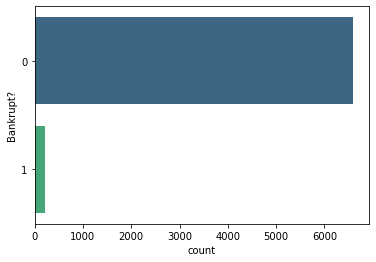

In [148]:
sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

In [149]:
ds["Bankrupt?"].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

### Split Target from Predictive Variables
- X: predictive variables
- y: target variable

In [150]:
X = ds.copy(deep=True)

y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

## Data Preparation

### Splitting the dataset
We splti 30% for testing. The sampling is stratified to make sure training and testing have the same distribution of target variable.

In [151]:
# Split the dataset intro train and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   shuffle = True, stratify=y, random_state=SEED)

### Correlation
We remove features whose absolute correlation coefficient are greater than 0.9

In [152]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9418288508327729
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9861217517131242
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.957838380759818
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9564272011651113
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.9130270278033344
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9994625329796241
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999896611498
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9994624071720175
 Operating Profit Rate vs.  Pre-tax net Intere

### Dealing with outliers
Random forests is efficient at detecting outliers in high-dimensional dataset https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest. Isolation forest algorithm randomly selects a feature and splits it between the min and max. This process is repeated recuresively to partition the outliers

In [153]:
print(x_train.shape)
print(x_test.shape)

(4773, 73)
(2046, 73)


In [154]:
x_train, x_test, y_train, y_test = remove_outliers(x_train, x_test, y_train, y_test)

In [155]:
print(x_train.shape)
print(x_test.shape)

(4717, 73)
(2021, 73)


In [156]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.971168
1    0.028832
Name: Bankrupt?, dtype: float64
0    0.969322
1    0.030678
Name: Bankrupt?, dtype: float64


### Dimension Reduction
We compute mutual information score and ANOVA F-value. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py explains that mutual information is an entrpoy-based method that is better at measuring non-linear relationship, whereas F-test statistics are better at measuring linear relationship.
We drop columns with low mutual information score or ANOVA F-value.

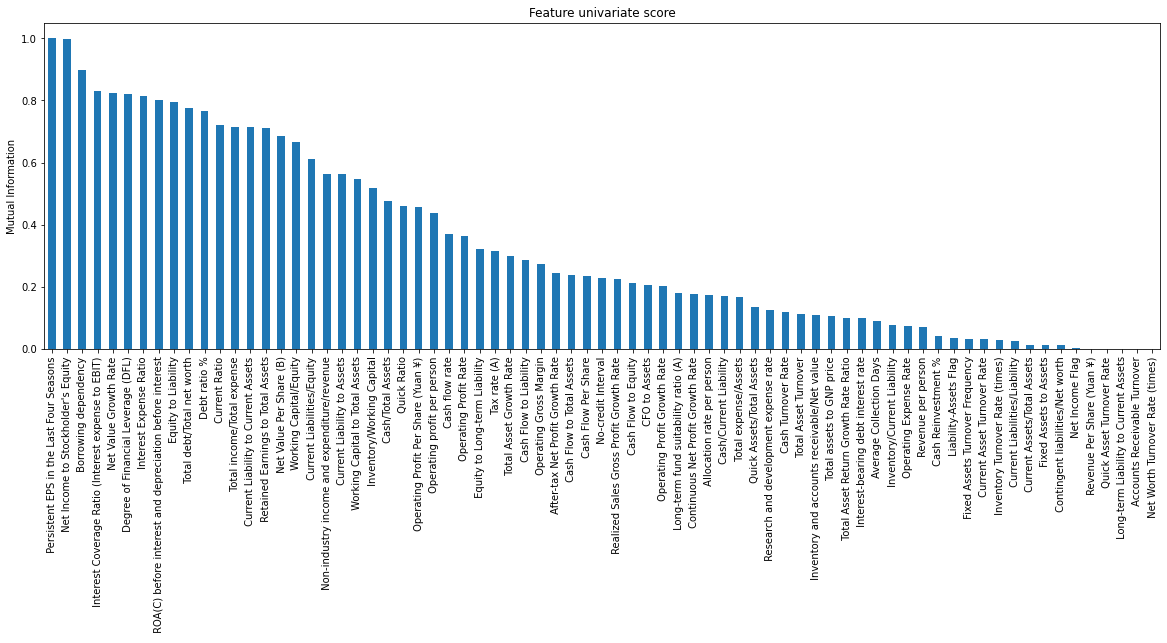

 Persistent EPS in the Last Four Seasons                    1.000000
 Net Income to Stockholder's Equity                         0.998625
 Borrowing dependency                                       0.896846
 Interest Coverage Ratio (Interest expense to EBIT)         0.829523
 Net Value Growth Rate                                      0.824464
 Degree of Financial Leverage (DFL)                         0.821296
 Interest Expense Ratio                                     0.814410
 ROA(C) before interest and depreciation before interest    0.801177
 Equity to Liability                                        0.793406
 Total debt/Total net worth                                 0.775404
 Debt ratio %                                               0.767509
 Current Ratio                                              0.720372
 Total income/Total expense                                 0.714933
 Current Liability to Current Assets                        0.714411
 Retained Earnings to Total Assets

In [157]:
mi_scores = MutualInfoScores(x_train, y_train)
mi_scores.loc[mi_scores > 0.2]

In [158]:
mi_scores.loc[mi_scores > 0.2].index

Index([' Persistent EPS in the Last Four Seasons',
       ' Net Income to Stockholder's Equity', ' Borrowing dependency',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Net Value Growth Rate', ' Degree of Financial Leverage (DFL)',
       ' Interest Expense Ratio',
       ' ROA(C) before interest and depreciation before interest',
       ' Equity to Liability', ' Total debt/Total net worth', ' Debt ratio %',
       ' Current Ratio', ' Total income/Total expense',
       ' Current Liability to Current Assets',
       ' Retained Earnings to Total Assets', ' Net Value Per Share (B)',
       ' Working Capital/Equity', ' Current Liabilities/Equity',
       ' Non-industry income and expenditure/revenue',
       ' Current Liability to Assets', ' Working Capital to Total Assets',
       ' Inventory/Working Capital', ' Cash/Total Assets', ' Quick Ratio',
       ' Operating Profit Per Share (Yuan ¥)', ' Operating profit per person',
       ' Cash flow rate', ' Operating P

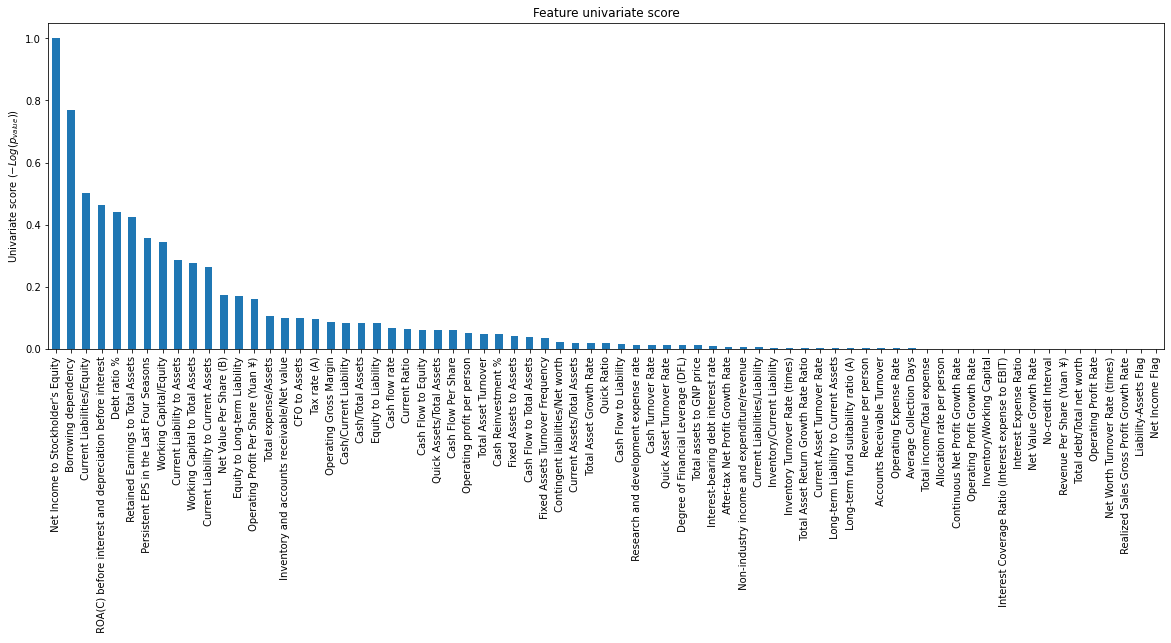

 Net Income to Stockholder's Equity                         1.000000
 Borrowing dependency                                       0.770567
 Current Liabilities/Equity                                 0.500427
 ROA(C) before interest and depreciation before interest    0.463902
 Debt ratio %                                               0.441154
 Retained Earnings to Total Assets                          0.425210
 Persistent EPS in the Last Four Seasons                    0.358444
 Working Capital/Equity                                     0.343314
 Current Liability to Assets                                0.285285
 Working Capital to Total Assets                            0.275719
 Current Liability to Current Assets                        0.264250
 Net Value Per Share (B)                                    0.173575
 Equity to Long-term Liability                              0.169901
 Operating Profit Per Share (Yuan ¥)                        0.159708
 Total expense/Assets             

In [159]:
f_scores = FTestScores(x_train, y_train)
f_scores.loc[f_scores > 0.1]

In [160]:
high_mi_columns = mi_scores.loc[mi_scores > 0.2].index
high_f_score_columns = f_scores.loc[f_scores > 0.1].index
kept_columns = high_mi_columns.union(high_f_score_columns).values
x_train = x_train[kept_columns]
x_test = x_test[kept_columns]

print(f"Keep {len(kept_columns)} columns")
kept_columns

Keep 42 columns


array([' After-tax Net Profit Growth Rate', ' Borrowing dependency',
       ' CFO to Assets', ' Cash Flow Per Share', ' Cash Flow to Equity',
       ' Cash Flow to Liability', ' Cash Flow to Total Assets',
       ' Cash flow rate', ' Cash/Total Assets',
       ' Current Liabilities/Equity', ' Current Liability to Assets',
       ' Current Liability to Current Assets', ' Current Ratio',
       ' Debt ratio %', ' Degree of Financial Leverage (DFL)',
       ' Equity to Liability', ' Equity to Long-term Liability',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Interest Expense Ratio', ' Inventory/Working Capital',
       " Net Income to Stockholder's Equity", ' Net Value Growth Rate',
       ' Net Value Per Share (B)', ' No-credit Interval',
       ' Non-industry income and expenditure/revenue',
       ' Operating Gross Margin', ' Operating Profit Growth Rate',
       ' Operating Profit Per Share (Yuan ¥)', ' Operating Profit Rate',
       ' Operating profit per pe

In [161]:
x_train = x_train[kept_columns]
x_test = x_test[kept_columns]

### Data Normalization:
We use the standard scaler to normalize the data

In [162]:
scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_test = scaler.transform(x_test)

## Simple Model
First we try out a simple model to get a sense of number of hidden layers needed.

In [37]:
def simple_model(units, loss, x_train, y_train, x_test, y_test, epochs=50, batch_size=16, cw=None):
    '''
    units: a list for number of units in each layer. The length of the list determines the number of hidden layers
    loss: loss function to minimize
    '''
    model = Sequential()
    for u in units:
        model.add(layers.Dense(units=u, activation="relu"))
    
    # Last layer should always have 1 neuron with sigmoid activation function
    model.add(layers.Dense(units=1, activation="sigmoid"))
    model.compile(loss=loss, metrics=['binary_accuracy'])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3,
        shuffle = True, stratify=y_train, random_state=SEED)
    EarlyStop = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, restore_best_weights=True)
    CallBacksList = [EarlyStop,]  
    model.fit(x_train, y_train, epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=cw,
        callbacks = CallBacksList,
        verbose='auto')
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = (y_pred_train>0.5).astype(int)
    y_pred_test = (y_pred_test>0.5).astype(int) 
    
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['0', '1']
    make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

Epoch 1/50
207/207 [==============================] - 2s 4ms/step - loss: 0.1457 - binary_accuracy: 0.9706 - val_loss: 0.1106 - val_binary_accuracy: 0.9753
Epoch 2/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0985 - binary_accuracy: 0.9721 - val_loss: 0.1206 - val_binary_accuracy: 0.9605
Epoch 3/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0907 - binary_accuracy: 0.9736 - val_loss: 0.1105 - val_binary_accuracy: 0.9710
Epoch 4/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0839 - binary_accuracy: 0.9730 - val_loss: 0.1127 - val_binary_accuracy: 0.9774
Epoch 5/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0834 - binary_accuracy: 0.9730 - val_loss: 0.1067 - val_binary_accuracy: 0.9753
Epoch 6/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0780 - binary_accuracy: 0.9749 - val_loss: 0.1120 - val_binary_accuracy: 0.9739
Epoch 7/50
207/207 [==============================] - 1s 6ms/ste

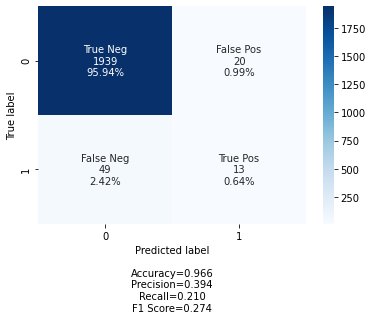

In [38]:
simple_model([64,32,16], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

Epoch 1/50
207/207 [==============================] - 6s 16ms/step - loss: 0.1736 - binary_accuracy: 0.9630 - val_loss: 0.1089 - val_binary_accuracy: 0.9718
Epoch 2/50
207/207 [==============================] - 2s 8ms/step - loss: 0.1020 - binary_accuracy: 0.9724 - val_loss: 0.1122 - val_binary_accuracy: 0.9668
Epoch 3/50
207/207 [==============================] - 2s 9ms/step - loss: 0.0957 - binary_accuracy: 0.9724 - val_loss: 0.1068 - val_binary_accuracy: 0.9689
Epoch 4/50
207/207 [==============================] - 1s 5ms/step - loss: 0.0877 - binary_accuracy: 0.9733 - val_loss: 0.1019 - val_binary_accuracy: 0.9760
Epoch 5/50
207/207 [==============================] - 3s 16ms/step - loss: 0.0870 - binary_accuracy: 0.9733 - val_loss: 0.1042 - val_binary_accuracy: 0.9739
Epoch 6/50
207/207 [==============================] - 1s 7ms/step - loss: 0.0815 - binary_accuracy: 0.9743 - val_loss: 0.1130 - val_binary_accuracy: 0.9668
Epoch 7/50
207/207 [==============================] - 2s 9ms/s

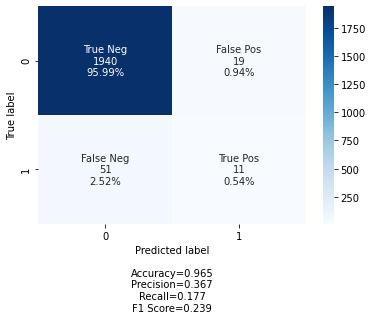

In [39]:
simple_model([64,32], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

Epoch 1/50
207/207 [==============================] - 2s 7ms/step - loss: 0.2072 - binary_accuracy: 0.9521 - val_loss: 0.1123 - val_binary_accuracy: 0.9732
Epoch 2/50
207/207 [==============================] - 1s 5ms/step - loss: 0.0999 - binary_accuracy: 0.9715 - val_loss: 0.1107 - val_binary_accuracy: 0.9760
Epoch 3/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0909 - binary_accuracy: 0.9730 - val_loss: 0.1080 - val_binary_accuracy: 0.9746
Epoch 4/50
207/207 [==============================] - 1s 6ms/step - loss: 0.0860 - binary_accuracy: 0.9721 - val_loss: 0.1047 - val_binary_accuracy: 0.9760
Epoch 5/50
207/207 [==============================] - 1s 5ms/step - loss: 0.0865 - binary_accuracy: 0.9739 - val_loss: 0.1071 - val_binary_accuracy: 0.9725
Epoch 6/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0815 - binary_accuracy: 0.9736 - val_loss: 0.1111 - val_binary_accuracy: 0.9739
Epoch 7/50
207/207 [==============================] - 1s 4ms/ste

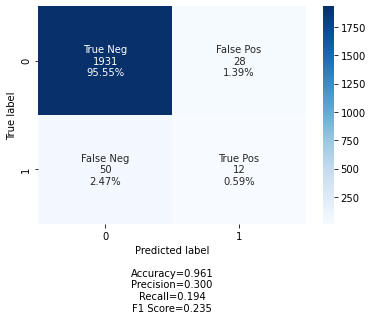

In [40]:
simple_model([48, 16], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

Epoch 1/50
207/207 [==============================] - 2s 6ms/step - loss: 0.1984 - binary_accuracy: 0.9688 - val_loss: 0.1069 - val_binary_accuracy: 0.9746
Epoch 2/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0989 - binary_accuracy: 0.9715 - val_loss: 0.1089 - val_binary_accuracy: 0.9732
Epoch 3/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0922 - binary_accuracy: 0.9697 - val_loss: 0.1064 - val_binary_accuracy: 0.9703
Epoch 4/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0867 - binary_accuracy: 0.9697 - val_loss: 0.1073 - val_binary_accuracy: 0.9753
Epoch 5/50
207/207 [==============================] - 1s 5ms/step - loss: 0.0852 - binary_accuracy: 0.9721 - val_loss: 0.1073 - val_binary_accuracy: 0.9732
Epoch 6/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0816 - binary_accuracy: 0.9709 - val_loss: 0.1089 - val_binary_accuracy: 0.9732
Epoch 7/50
207/207 [==============================] - 1s 5ms/ste

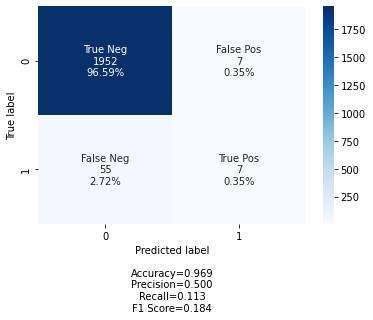

In [41]:
simple_model([32,16,4], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

A smaller neural network seems to generalize better for our dataset, because the dataset is small.

## Hyper parameters tuning:
Referencs:
- https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
- https://keras.io/guides/keras_tuner/getting_started/
- https://keras.io/api/utils/serialization_utils/
- https://www.tensorflow.org/tutorials/keras/keras_tuner
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

### Class Weights
Because the target variable distribution is imbalanced, we use class weight to penalize wrong prediction of the minority class more.

In [42]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.5148439205413665, 1: 17.341911764705884}

In [43]:
tune_objective = 'val_f1'
EarlyStop = EarlyStopping(monitor=tune_objective, patience=5, verbose=0, restore_best_weights=True)
ReduceLR = ReduceLROnPlateau(monitor=tune_objective, mode='max', factor=0.2, patience=3, min_lr=1e-5)

CallBacksList = [EarlyStop, ReduceLR]  

### K-fold Validation
The dataset is small, so we use k-fold validation to make sure hyper parameter tuning evaluates models using all training data.

In [44]:
def kfold_split(x, y, k):
    x = np.array(x)
    y = np.array(y)
    kfold = StratifiedKFold(n_splits=k)
    x_train, x_val, y_train, y_val = [], [], [], []
    for train_index, val_index in kfold.split(x, y):
        x_train.append(x[train_index])
        x_val.append(x[val_index])
        # Need to use y directly because y_train is Series
        y_train.append(y[train_index])
        y_val.append(y[val_index])
    return x_train, x_val, y_train, y_val

### Custom Model
We implement our own model class that inherits keras' hyper model. It allows tuning of the following parameters:
- Number of units in each layer
- Activation function: choose between sigmoid, relu and tanh
- Kernel initializer: How to set initial weight in each layer. We choose between Glorot normal initializer and Glorot uniform initializer. https://keras.io/api/layers/initializers/
- Learning rate: for the Adam optimizer https://keras.io/api/optimizers/adam/
- Loss type: binary classification or focal loss.
https://towardsdatascience.com/focal-loss-a-better-alternative-for-cross-entropy-1d073d92d075 provides a good explanation of their difference. In essence focal loss function focuses on cases that are misclassfified, so it's useful when the classes are imbalanced. It takes a parameter gamma.
- Dropout and dropout rate: What percent of the input should be set to 0. Use to regulate overfitting.
- Oversampling: We use Synthetic Minority Oversampling Technique (SMOTE) to generate more data points for the minority class.
- Undersampling: We use near miss strategy https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#prototype-selection-under-sampling-by-selecting-existing-samples to remove similar data points from the majority class

In [45]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, metrics=None, k=3):
        self.k = k
        if metrics:
            self.metrics = metrics
        else:
            self.metrics= [
                "accuracy",
                tf.keras.metrics.AUC(name="auc"), 
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                f1
            ]

    def build(self ,hp):
        hp_units_1 = hp.Choice("Layer 1", [64, 96, 128])
        hp_units_2 = hp.Choice("Layer 2", [4, 8, 16, 32]) # 64
        hp_activation_1 = hp.Choice("activation 1", ["sigmoid", "relu", "tanh"])
        hp_activation_2 = hp.Choice("activation 2", ["sigmoid", "relu", "tanh"])
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-5, 1e-3, sampling="log", default=1e-5)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.1, 2.0, 3.0])
        hp_dropout_2 = hp.Choice("dropout rate 2", [0.1, 0.15, 0.2, 0.25])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        #kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation_1,
                        input_dim = x_train.shape[-1]   
                           )) 
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation_2))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=hp_dropout_2))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics= self.metrics)
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                    metrics= self.metrics)
    
        return model

    def fit(self, hp, model, x, y, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [64, 96, 128])
        hp_sample = hp.Choice("sample", ["over", "under", "none"])
        hp_oversample_rate = hp.Choice("oversample_rate", [0.05, 0.1, 0.15, 0.2])
        hp_undersample_rate = hp.Choice("undersample_rate", [0.05, 0.1, 0.15])
        hp_near_miss_version = hp.Choice("near_miss_version", [1, 2])
        
        measures = ['val_precision', 'val_recall', 'val_f1', 'val_auc']
        results = pd.DataFrame(index=range(self.k), columns=measures)

        x_train, x_val, y_train, y_val = kfold_split(x, y, self.k)
        for i in range(self.k):
            x_train_i, y_train_i = x_train[i], y_train[i]
            # over/under sample after splitting validation data. Don't use synthetic data for validation.
            if hp_sample == 'over':
                x_train_i, y_train_i = oversample(hp_oversample_rate, x_train[i], y_train[i])
            elif hp_sample == 'under':
                x_train_i, y_train_i = undersample(hp_undersample_rate, x_train[i], y_train[i], hp_near_miss_version)
            hist = None
            ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train_i), y=y_train_i)))
            try:
                hist = model.fit(
                    x_train_i, y_train_i,
                    # Tune whether to shuffle the data in each epoch.
                    shuffle=hp.Boolean("shuffle"),
                    validation_data=(x_val[i], y_val[i]),
                    batch_size = hp_batch_size,
                    class_weight = ClassWeights,
                    **kwargs,
                )
                for m in measures:
                    results.iloc[i][m] = hist.history[m][-1]

            except:
                results.iloc[i] = 0

        avg_measures = {}
        for m in measures:
            avg_measures[m] = results[m].mean()
        return avg_measures

def tune(x_train, y_train):
    tuner = kt.BayesianOptimization(
        hypermodel = MyHyperModel(),
        objective = kt.Objective(tune_objective, direction="max"), 
        seed = SEED,
        max_trials = 30,
        overwrite=True,
        directory = 'Deep_learning_project',
        project_name = "Default_predictions"
    )
    tuner.search(x_train, y_train,
        epochs = 50,
        verbose = 2,
        initial_epoch = 0,
        callbacks = CallBacksList,
        use_multiprocessing = True,
    )
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. The optimal hyper parameters are:
    The first layer: {best_hps.get("Layer 1")}. \n
    The first layer activation function: {best_hps.get("activation 1")}. \n
    The second layer: {best_hps.get("Layer 2")}. \n
    The second layer activation function: {best_hps.get("activation 2")}. \n
    Layer 2 Dropout: {best_hps.get("Dropout 2")}. \n
    Layer 2 Dropout rate: {best_hps.get("dropout rate 2")} \n
    The kernel initializer: {best_hps.get("kernel_initializer")}. \n
    The loss function: {best_hps.get("loss_type")}. \n  
    The learning rate: {best_hps.get("learning_rate")}. \n
    The batch size: {best_hps.get("batch_size")}. \n
    Sample: {best_hps.get("sample")}. \n
    Oversample rate: {best_hps.get("oversample_rate")}. \n
    Undersample rate: {best_hps.get("undersample_rate")}. \n
    NearMiss version:  {best_hps.get("near_miss_version")}. \n
    Shuffle: {best_hps.get("shuffle")}. \n
    Gamma: {best_hps.get("Gamma")}. \n
    """)
    return tuner

In [60]:
tuner = tune(x_train, y_train)

Trial 30 Complete [00h 00m 08s]
val_f1: 0.22657900551954904

Best val_f1 So Far: 0.3216448277235031
Total elapsed time: 00h 13m 51s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete. The optimal hyper parameters are:
    The first layer: 64. 

    The first layer activation function: sigmoid. 

    The second layer: 8. 

    The second layer activation function: sigmoid. 

    Layer 2 Dropout: False. 

    Layer 2 Dropout rate: 0.25 

    The kernel initializer: glorot_normal. 

    The loss function: BC. 
  
    The learning rate: 0.001. 

    The batch size: 128. 

    Sample: none. 

    Oversample rate: 0.1. 

    Undersample rate: 0.15. 

    NearMiss version:  2. 

    Shuffle: True. 

    Gamma: 0.1. 

    


In [74]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_params = MyHyperModel().build(best_hps)
best_model_params.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2752      
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


### Visualize Best Model K-fold Result

In [ ]:
def get_mean_metrics(model, x, y, k=5, n_epochs=20):
    mean_values = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                   "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    mean_values_val = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                       "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']


    x_train, x_val, y_train, y_val = kfold_split(x, y, k)

    for i in range(k):
        hist = model.fit(x_train[i],
            y_train[i],
            verbose=0,             
            epochs = n_epochs,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            validation_data = (x_val[i], y_val[i]),
            batch_size = best_hps.get("batch_size"),
            class_weight = ClassWeights,
        )
        for m in metrics:
            
            mean_values[m] = list(map(add, mean_values[m], hist.history[f"{m}"]))
            mean_values_val[m] = list(map(add, mean_values_val[m], hist.history[f"val_{m}"]))
    

    for m in metrics:
        mean_values[m] = np.array(mean_values[m])/k
        mean_values_val[m] = np.array(mean_values_val[m])/k
    return mean_values, mean_values_val

# This function plot the "metrics" and the "val_metrics" values.
def visualize_mean_metrics(mean_values, mean_values_val, metrics):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    fig, ax = plt.subplots(len(metrics), 1, figsize=(20,15))
    
    for idx, m in enumerate(metrics):
    
        loss = mean_values[m]
        val_loss = mean_values_val[m]
        epochs = range(1, len(loss)+1)
        ax[idx].plot(epochs, loss, "g", label=f"Training {m}")
        ax[idx].plot(epochs, val_loss, "b", label=f"Validation {m}")
        ax[idx].legend(loc="best")
    plt.xlabel("Epochs")
    fig.tight_layout()
    fig.show();

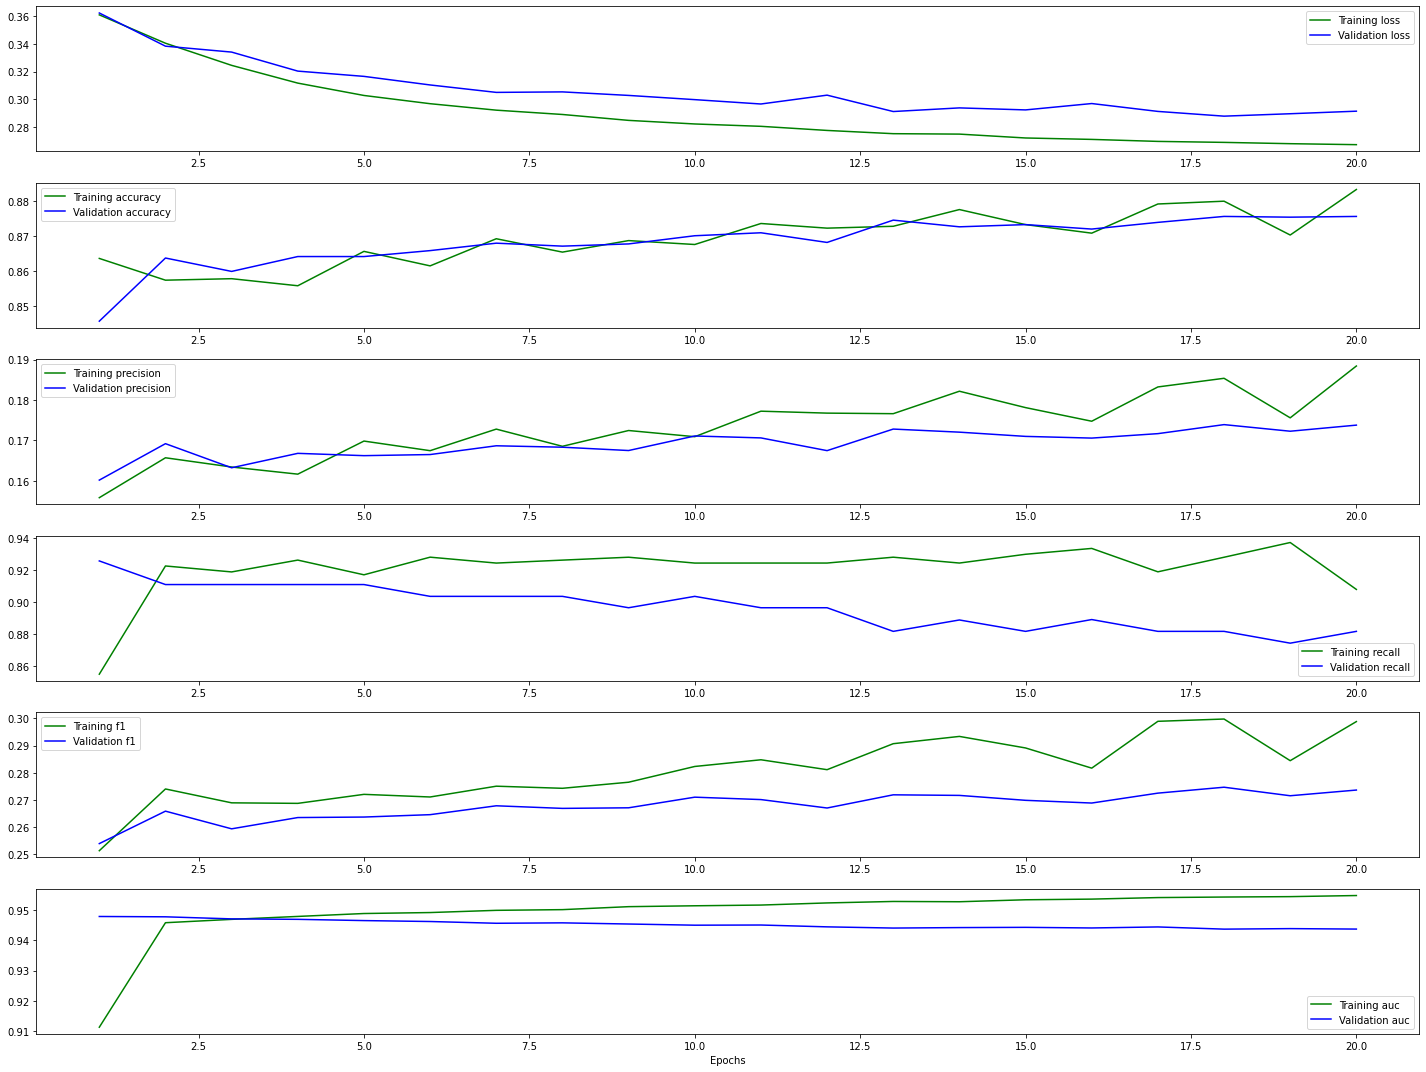

In [ ]:
mean_values, mean_values_val = get_mean_metrics(best_model_params, x_train, y_train)
visualize_mean_metrics(mean_values, mean_values_val, ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc'])

## Fit Model with All Training Data

In [ ]:
def fit_with_sample(x, y, best_hps, n_epochs=20):
    if best_hps.get("sample") == "over":
        x, y = oversample(best_hps.get("oversample_rate"), x, y)
    elif best_hps.get("sample") == "under":
        x, y = undersample(best_hps.get("undersample_rate"), x, y, best_hps.get("near_miss_version"))
    ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y), y=y)))
    best_model_params.fit(x, y,
        epochs = n_epochs,
        # Tune whether to shuffle the data in each epoch.
        shuffle = True,
        batch_size = best_hps.get("batch_size"),
        class_weight = ClassWeights,
        callbacks=[
            EarlyStopping(monitor='f1', patience=6, verbose=0, restore_best_weights=True),
            ReduceLROnPlateau(monitor='f1', mode='max', factor=0.2, patience=3, min_lr=1e-5),
        ],
    )

In [ ]:
fit_with_sample(x_train, y_train, best_hps)

Epoch 1/20
37/37 [==============================] - 0s 5ms/step - loss: 0.2422 - accuracy: 0.8932 - auc: 0.9622 - precision: 0.2042 - recall: 0.9338 - f1: 0.3220 - lr: 2.0000e-04
Epoch 2/20
37/37 [==============================] - 0s 8ms/step - loss: 0.2412 - accuracy: 0.8942 - auc: 0.9624 - precision: 0.2058 - recall: 0.9338 - f1: 0.3325 - lr: 2.0000e-04
Epoch 3/20
37/37 [==============================] - 0s 9ms/step - loss: 0.2406 - accuracy: 0.8879 - auc: 0.9623 - precision: 0.1963 - recall: 0.9338 - f1: 0.3195 - lr: 2.0000e-04
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.2402 - accuracy: 0.8859 - auc: 0.9623 - precision: 0.1936 - recall: 0.9338 - f1: 0.3148 - lr: 2.0000e-04
Epoch 5/20
37/37 [==============================] - 0s 5ms/step - loss: 0.2400 - accuracy: 0.8891 - auc: 0.9625 - precision: 0.1981 - recall: 0.9338 - f1: 0.3171 - lr: 2.0000e-04
Epoch 6/20
37/37 [==============================] - 0s 6ms/step - loss: 0.2392 - accuracy: 0.8895 - auc: 

In [ ]:
y_pred_train = best_model_params.predict(x_train)
y_pred_test = best_model_params.predict(x_test)

In [ ]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

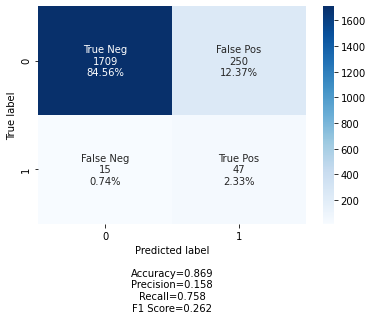

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

              precision    recall  f1-score   support

  No Default       0.99      0.87      0.93      1959
     Default       0.16      0.76      0.26        62

    accuracy                           0.87      2021
   macro avg       0.57      0.82      0.59      2021
weighted avg       0.97      0.87      0.91      2021



In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
ACCURACY,ACCURACY,0.888700,0.868877
PRECISION,PRECISION,0.197512,0.158249
RECALL,RECALL,0.910592,0.815224
F1 SCORE,F1 SCORE,0.632700,0.594943
AUC,AUC,0.910592,0.815224


***

In [ ]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)

Time taken to run in minutes: 87.87711962175


## Interpret Model
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

In [168]:
def shap_samples(x, y, samples):
    default = x[y == 1]
    no_default = x[y == 0]
    return np.append(shap.sample(no_default, samples, random_state=SEED), shap.sample(default, samples, random_state=SEED), axis = 0)

In [169]:

explainer = shap.KernelExplainer(best_model_params.predict, shap_samples(x_train, y_train, 100))
y_test_default = y_test.loc[y_test == 1]
x_test_default = x_test[y_test_default]
y_test_no_default = y_test.loc[y_test == 0]
x_test_no_default = x_test[y_test_no_default]
# Sample 100 from non default case and all of default cases
shap_datapoints = np.append(shap_samples(x_test, y_test, 100), x_test_default, axis = 0)
shap_values = explainer.shap_values(shap_datapoints, nsamples=50)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 224/224 [03:44<00:00,  1.00s/it]


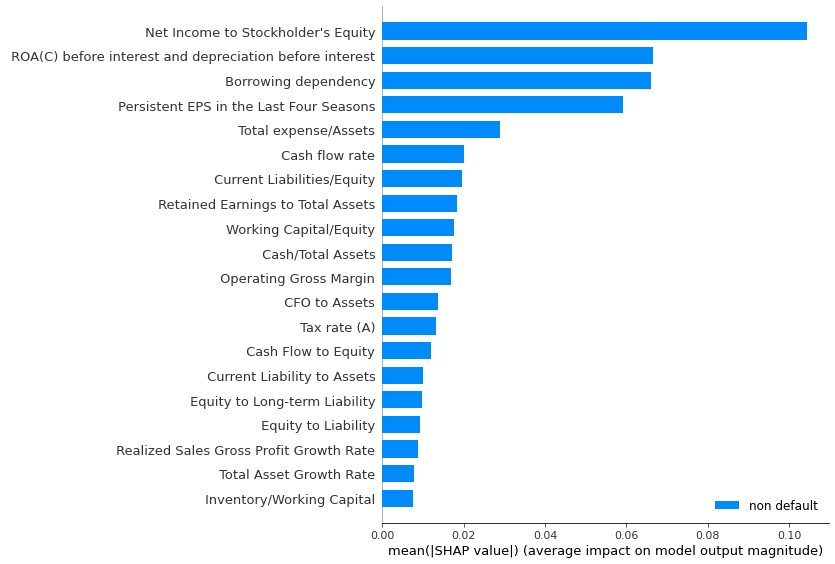

In [170]:
shap.summary_plot(shap_values, feature_names=kept_columns, class_names=['non default', 'default'])